# Analysis 2.2
- Outcome: CGC in 10 years
- Model: Logistic regression
- Risk score: predicted score from logreg model
- Feature selection: Significant variables based on univariate and multivariate analysis
- Drop patients with missing sex 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import percentileofscore
from helpers.utils import generate_risk_percentile_df, classification_metrics, event_pretty_label, save_to_json

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [27]:
%%R
source("utils.R")
library(survival)

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [46]:
model = 'logreg'
cancer = 'CGC'
ro.globalenv['model'] = model
ro.globalenv['cancer'] = cancer

analysis_num = '2.2'

In [47]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

outcome_interval <- "_10yr"
outcome <- ifelse(cancer == "ugica", cancer, paste0("ugica_", cancer)) 
outcome_event <- paste0(tolower(cancer), outcome_interval)
model_filename <- paste0(model, "_", outcome_event, ".rds")

In [28]:
univariate_filename = f'./../results/univariate_analysis_{analysis_num}_{cancer}.csv'
multivariate_filename = f'./../results/multivariate_analysis_{analysis_num}_{cancer}.csv'
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_{cancer}.csv'
model_filename = f'{model}_{cancer}.rds'
outcome_event = r['outcome_event'][0]
outcome_interval = r['outcome_interval'][0]

In [10]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS 
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)
ro.globalenv['model_filename'] = model_filename

## Univariate analysis - logistic regression

### Factorize categorical vars and set reference levels

In [11]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [12]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex_missing"                   "race_clean"                   
 [3] "ethnicity"                     "alcohol_binary"               
 [5] "tobacco_binary"                "hpylori_active_chronic_binary"
 [7] "hnca"                          "achalasia"                    
 [9] "pud"                           "gerd"                         
[11] "cad"                           "famhx_cancer"                 
[13] "famhx_esophagealca"            "famhx_gastricca"              
[15] "famhx_colonca"                 "famhx_barretts"               
[17] "ASA"                           "PPI"                          
[19] "NSAID"                         "age"                          
[21] "BMI_baseline_all"             


In [13]:
%%R
# HRs, 95% CIs, p-values
results_list <- list()

for (var in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[var]]))) < 2) next

    # Build formula
    model <- train_logreg_model(train_set = r_df_normal, selected_vars = var, outcome = outcome_event)

    # Get model summary in formatted dataframe 
    model_df <- get_logreg_univariate_summary(model, var, categorical_vars)
    results_list[[var]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to con

In [14]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [15]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,OR,CI_lower,CI_upper,p_value
0,sex_missing.(Intercept),sex_missing,(Intercept),0.000013,0.000007,0.000022,0.000000e+00
1,sex_missing.sex_missingMALE,sex_missing,MALE,4.724557,2.601983,9.306340,1.429186e-06
2,race_clean.(Intercept),race_clean,(Intercept),0.000049,0.000034,0.000068,0.000000e+00
5,race_clean.race_cleanNo matching concept,race_clean,No matching concept,0.356324,0.180498,0.663053,1.702548e-03
7,ethnicity.(Intercept),ethnicity,(Intercept),0.000054,0.000040,0.000071,0.000000e+00
9,ethnicity.ethnicityNo matching concept,ethnicity,No matching concept,0.115215,0.034773,0.282626,3.282623e-05
10,alcohol_binary.(Intercept),alcohol_binary,(Intercept),0.000035,0.000026,0.000046,0.000000e+00
12,tobacco_binary.(Intercept),tobacco_binary,(Intercept),0.000025,0.000017,0.000034,0.000000e+00
13,tobacco_binary.tobacco_binary1,tobacco_binary,1,3.236682,1.930823,5.356918,5.720747e-06
14,hpylori_active_chronic_binary.(Intercept),hpylori_active_chronic_binary,(Intercept),0.000035,0.000027,0.000045,0.000000e+00


## Feature selection

In [16]:
%%R 
selected_vars <- final_results %>%
    filter(Level != "(Intercept)") %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "sex_missing"     "race_clean"      "ethnicity"       "tobacco_binary" 
 [5] "pud"             "cad"             "famhx_cancer"    "famhx_gastricca"
 [9]

 "ASA"             "PPI"             "NSAID"           "age"            


### Forest plot for univariate visualization

In [17]:
%%R 
forestplot_df <- final_results[(final_results$Variable %in% selected_vars) & (final_results$Level != '(Intercept)'), ]
forestplot_df$Variable_full <- rownames(forestplot_df)

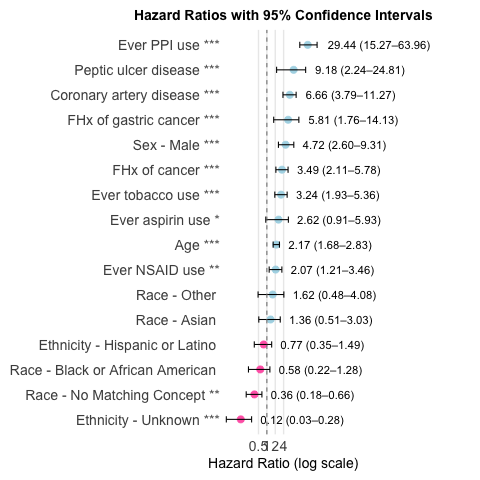

In [18]:
%%R 
plot_univariate_forest(forestplot_df)

## Logistic regression multivariate model training

#### Split dataset into training and validation

In [19]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome_event, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
logreg_model <- train_logreg_model(train_set, selected_vars, outcome_event, model_func=glm)

[1] "Dataset Controls 34122" "Dataset Cases 61"      
[1] "Training Controls 27300" "Training Cases 47"      
[1] "Validation Controls 6822" "Validation Cases 14"     



#### Multivariate analysis

In [20]:
%%R 
# Saves hazard ratio from multivariate analysis into file
multivariate_df <- save_multivariate_logreg_results(logreg_model, multivariate_filename)

Multivariate results saved to ./../results/multivariate_analysis_2.2_CGC.csv 


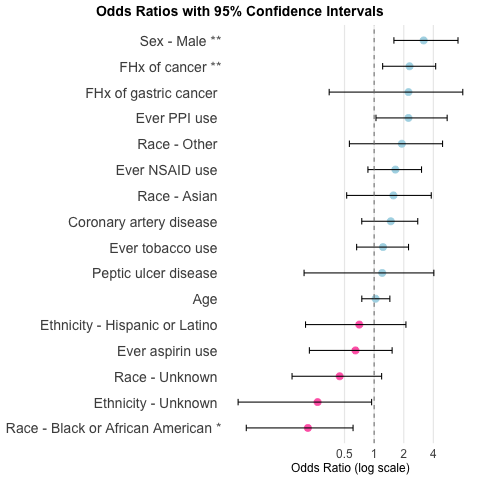

In [21]:
%%R 
plot_multivariate_forest(multivariate_df)

## Results

### Predict events

In [30]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)
event_5_years <- r_df_validation_risk[[outcome_event]]

# Get the predicted risk 
risk_5_years <- calculate_risk_from_logreg(logreg_model, validation_set)
r_df_validation_risk$pred_risk <- risk_5_years

In [31]:
%%R 
# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])


In [34]:
%%R 
# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)



Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.765 
Sensitivity: 0.7142857 
Specificity: 0.7008209 
PPV: 0.00487567 
NPV: 0.9991641 
NNS: 247.5416 
     predicted_class
event    0    1
    0 4781 2041
    1    4   10


### Sensitivity and Metrics at threshold that maximizes Youdens

In [35]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.765 
Sensitivity: 0.9285714 
Specificity: 0.6367634 
PPV: 0.005218788 
NPV: 0.9997699 
NNS: 200.4555 
     predicted_class
event    0    1
    0 4344 2478
    1    1   13


### AUROC curves and PR curve

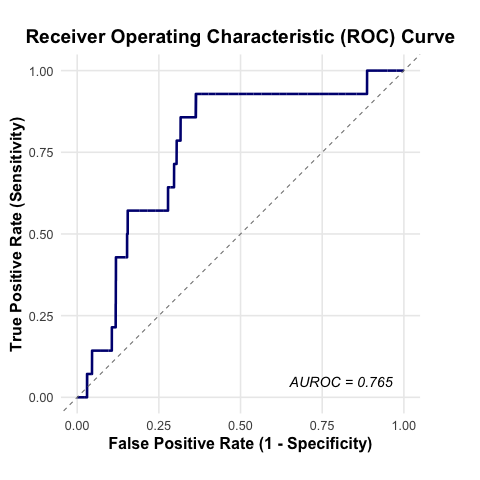

In [36]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

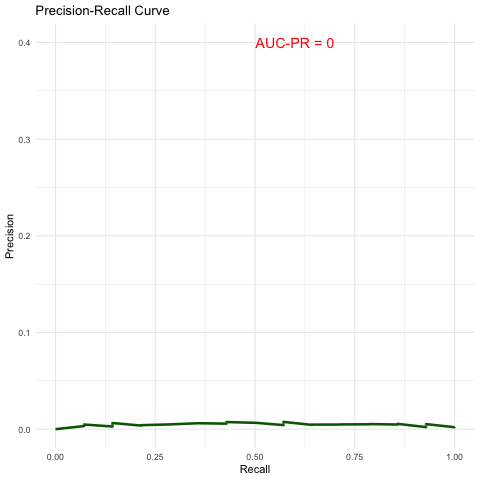

In [37]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [38]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk'
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk[pred_risk], optimal_threshold, kind='weak')/100.
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

In [39]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,sex,age_bucket,visit_year_bucket,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr,ugica_1yr,escc_1yr,eac_1yr,cgc_1yr,ncgc_1yr,ugica_3yr,escc_3yr,eac_3yr,cgc_3yr,ncgc_3yr,ugica_10yr,escc_10yr,eac_10yr,cgc_10yr,ncgc_10yr,pred_risk,actual_percentile,risk_group,risk_p0.5,risk_p0.6,risk_p0.6356056173200703,risk_p0.7,risk_p0.75,risk_p0.8,risk_p0.85,risk_p0.9,risk_p0.95,risk_p0.975,risk_p0.99,risk_p1,high_risk,high_risk_youden
1,59.071869,0,0,0,0,0,No matching concept,MALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000581,0.415886,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.993840,0,0,0,0,0,No matching concept,FEMALE,60-69,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000107,0.065535,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66.726899,0,0,0,0,0,White,MALE,40-49,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003540,0.871123,0.85,1,1,1,1,1,1,1,0,0,0,0,0,0,1
4,157.043121,0,0,0,0,0,No matching concept,FEMALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000314,0.253803,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.164271,0,0,0,0,0,White,MALE,70-79,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008229,0.971036,0.95,1,1,1,1,1,1,1,1,1,0,0,0,0,1


In [40]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events = [f'ugica{outcome_interval}', f'escc{outcome_interval}', f'eac{outcome_interval}', f'cgc{outcome_interval}', f'ncgc{outcome_interval}']
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", outcome_event, race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", outcome_event, sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", outcome_event, age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", outcome_event, visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [41]:
df_results.tail()

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
70,high_risk_youden,youden,cgc_10yr,70-79,1953,7,771,6 (0.8%),0.8,6,765,1,1188,0.609184,0.390816,85.714286,60.829493,0.778210,99.915896,144.070250,0.465438
71,high_risk_youden,youden,cgc_10yr,50-59,1269,2,408,2 (0.5%),0.5,2,406,0,863,0.680566,0.319434,100.000000,68.006304,0.490196,100.000000,204.000000,0.680063
72,high_risk_youden,youden,cgc_10yr,2011-2014,2860,8,1076,7 (0.7%),0.7,7,1069,1,1791,0.626918,0.373082,87.500000,62.622378,0.650558,99.944196,168.136728,0.501224
73,high_risk_youden,youden,cgc_10yr,2015-2018,2295,5,896,5 (0.6%),0.6,5,891,0,1404,0.612609,0.387391,100.000000,61.176471,0.558036,100.000000,179.200000,0.611765
74,high_risk_youden,youden,cgc_10yr,2019-2022,1667,1,519,1 (0.2%),0.2,1,518,0,1149,0.689448,0.310552,100.000000,68.926215,0.192678,100.000000,519.000000,0.689262


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [42]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
60,high_risk_youden,youden,cgc_10yr,No matching concept,2332,6,432,5 (1.2%),1.2,5,427,1,1905,0.816938,0.183062,83.333333,81.689537,1.157407,99.947534,90.502528,0.650229
61,high_risk_youden,youden,cgc_10yr,White,2528,4,1552,4 (0.3%),0.3,4,1548,0,980,0.388626,0.611374,100.000000,38.765823,0.257732,100.000000,388.000000,0.387658
62,high_risk_youden,youden,cgc_10yr,Black or African American,1473,3,102,3 (2.9%),2.9,3,99,0,1374,0.932927,0.067073,100.000000,93.279022,2.941176,100.000000,34.000000,0.932790
63,high_risk_youden,youden,cgc_10yr,Asian,275,1,238,1 (0.4%),0.4,1,237,0,38,0.141304,0.858696,100.000000,13.818182,0.420168,100.000000,238.000000,0.138182
64,high_risk_youden,youden,cgc_10yr,Other,214,0,167,0 (0.0%),0.0,0,167,0,47,0.219626,0.780374,0.000000,21.962617,0.000000,100.000000,inf,-0.780374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,risk_p0.9,0.9,ugica_10yr,all,6775,61,684,11 (1.6%),1.6,11,673,50,6102,0.894236,0.105764,18.032787,90.066421,1.608187,99.187256,125.716061,0.080992
35,risk_p0.95,0.95,ugica_10yr,all,6775,61,342,11 (3.2%),3.2,11,331,50,6444,0.944266,0.055734,18.032787,95.114391,3.216374,99.230059,40.875842,0.131472
40,risk_p0.975,0.975,ugica_10yr,all,6775,61,171,4 (2.3%),2.3,4,167,57,6608,0.967232,0.032768,6.557377,97.535055,2.339181,99.144786,67.386921,0.040924
45,risk_p0.99,0.99,ugica_10yr,all,6775,61,69,1 (1.4%),1.4,1,68,60,6707,0.981276,0.018724,1.639344,98.996310,1.449275,99.113344,177.740008,0.006357


In [43]:
df_results.to_csv(risk_results_filename)

### Save model, threshold and validation set

In [49]:
%%R 
# Save model
saveRDS(logreg_model, model_filename)

In [45]:
selected_vars = list(r['selected_vars'])  

model_variables = {
    outcome_event: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
